# Imports

In [ ]:
from langchain_core.messages import HumanMessage
from langchain_groq import ChatGroq
import pandas as pd
import os
import gradio as gr
import shutil
import sys
import time
from datetime import datetime

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

# Model Definition

In [3]:
# Initialize the LLM

model_name = "openai/gpt-oss-20b"
temperature = 0.01

llm = ChatGroq(
    model_name=model_name,
    temperature=temperature,
    max_tokens=None,
    groq_api_key=os.environ["GROQ_API_KEY"],
    timeout=60
)

In [4]:
import time
from openai import RateLimitError

def enforce_rate_limit(messages):
    while True:
        try:
            return (
                llm.invoke(messages)
            )
        except RateLimitError as e:
            print("Rate limit reached. Waiting 60 seconds...")
            time.sleep(60)

# Summary Generation

In [5]:
def issue_summary_generation_prompt(topic: str, summary_text):
    return f"""
    You are a highly skilled code quality analysis assistant.

    Your task is to generate a clear, concise, and insightful **overall summary** for a software repository, focused specifically on the topic: **{topic}**.

    You are provided with a collection of **raw code review issues** which are extracted from individual files or modules related to this topic:
    ------------------------
    {summary_text}
    ------------------------

    Please analyze the issues and synthesize the key patterns, recurring violations, and critical observations related to **{topic}**. Your summary should:

    1. Highlight only the most significant or frequent types of issues found in the input.
    2. Identify common trends, such as repeated bad practices or patterns of neglect.
    3. Emphasize any critical or high-severity issues that require urgent remediation. Be specific where possible.
    4. Highlight major concerns only. Do not comment on what needs to be changed.
    4. Maintain a professional, concise, and objective tone.

    Return only the final textual summary. Do not repeat or restate the raw input. Do not format your response as a list or dictionary — only provide a well-written paragraph.
    """

def generate_overall_issue_summary(topic: str, summary_text: list[str]) -> dict:
    
    # Combine and build prompt
    combined_prompt = issue_summary_generation_prompt(topic, summary_text)

    # Invoke LLM
    # response = llm.invoke([HumanMessage(content=combined_prompt)])
    messages = [HumanMessage(content=combined_prompt)]
    response = enforce_rate_limit(messages)

    return response.content

In [6]:
def refactor_summary_generation_prompt(topic: str, summary_text):
    return f"""
    You are a highly skilled code quality analysis assistant.

    Your task is to generate a clear, concise, and insightful **refactoring summary** for a software repository, focused specifically on the topic: **{topic}**.

    You are provided with a list of summaries describing the **code changes that were done** in individual files or modules related to the topic: {topic}
    ------------------------
    {summary_text}
    ------------------------

    Please analyze the described changes and synthesize the key improvements, recurring refactor patterns, and overall impact of the modifications related to **{topic}**. Your summary should:

    1. Highlight the most important or impactful changes made across the codebase.
    2. Identify common refactoring patterns or trends (e.g., modularization, removal of duplication, performance improvements).
    3. Mention any changes that address critical or high-severity issues, if applicable.
    4. The 'summary_text' contains all the **changes made**.
    5. Do not mention what can be refactored, but only on what changes are actually made.
    6. Maintain a professional, concise, and objective tone.

    Return only the final textual summary. Do not repeat or restate the raw input. Do not format your response as a list or dictionary — only provide a well-written paragraph.
    """

def generate_overall_refactor_summary(topic: str, summary_text: list[str]) -> dict:
    
    # Combine and build prompt
    combined_prompt = refactor_summary_generation_prompt(topic, summary_text)

    # Invoke LLM
    # response = llm.invoke([HumanMessage(content=combined_prompt)])
    messages = [HumanMessage(content=combined_prompt)]
    response = enforce_rate_limit(messages)

    return response.content

In [7]:
def overall_issue_summary_generation_prompt(text_code_styling, text_dry_modularity, text_security):
    return f"""You are a code quality analysis assistant.

You are given three issue summaries highlighting problems identified in a codebase, each focusing on a different aspect:
1. Code Styling – formatting inconsistencies, naming violations, and readability issues.
2. DRY and Modularity – code duplication, poor abstraction, and lack of reuse.
3. Security Compliance – unsafe practices, vulnerabilities, and deviations from security best practices.

Each summary is provided below. Your task is to:
- Carefully review the three issue summaries.
- Synthesize and interpret the most important insights across all three areas.
- Identify critical patterns, recurring violations, or any systemic problems affecting code quality.
- Write a **concise, high-level summary** that reflects the overall quality and areas needing improvement.
- Do **not** copy or restate the full summaries; focus on generating a holistic assessment of the issues only, do not suggest any changes.

Return only the summary text. Do not include any formatting, lists, or metadata — just plain text.

---

**Code Styling Issues Summary:**
{text_code_styling}

**DRY & Modularity Issues Summary:**
{text_dry_modularity}

**Security Compliance Issues Summary:**
{text_security}
"""

def generate_overall_repo_issue_summary(text1, text2, text3):
    
    # Combine and build prompt
    combined_prompt = overall_issue_summary_generation_prompt(text1, text2, text3)

    # Invoke LLM
    # response = llm.invoke([HumanMessage(content=combined_prompt)])
    messages = [HumanMessage(content=combined_prompt)]
    response = enforce_rate_limit(messages)

    return response.content

In [8]:
def overall_refactor_summary_generation_prompt(text_code_styling, text_dry_modularity, text_security):
    return f"""You are a code quality analysis assistant.

You are given summaries describing refactoring changes made to a code repository, grouped into three key areas:
1. Code Styling – improvements related to formatting, naming conventions, readability, and consistency.
2. DRY and Modularity – changes addressing code duplication, abstraction, reuse, and structural modularity.
3. Security Compliance – enhancements targeting security risks, vulnerabilities, and adherence to best practices.

Each summary below describes the changes that have already been made. Your task is to:
- Read and analyze the three refactoring summaries carefully.
- Synthesize and interpret the overall improvements to the codebase.
- Identify recurring patterns or themes across the changes.
- Write a **concise, high-level summary** of how the refactoring has improved the codebase.
- Emphasize the overall impact on maintainability, readability, structure, and security.

Return only the final summary text — do not include lists, formatting, or restate the input directly.

---

**Code Styling Refactoring Summary:**
{text_code_styling}

**DRY & Modularity Refactoring Summary:**
{text_dry_modularity}

**Security Compliance Refactoring Summary:**
{text_security}
"""

def generate_overall_repo_refactor_summary(text1, text2, text3):
    
    # Combine and build prompt
    combined_prompt = overall_refactor_summary_generation_prompt(text1, text2, text3)

    # Invoke LLM
    # response = llm.invoke([HumanMessage(content=combined_prompt)])
    messages = [HumanMessage(content=combined_prompt)]
    response = enforce_rate_limit(messages)

    return response.content

# Final Answer

In [9]:
# Importing Agents
from ReviewAgents.CodeStyle import create_code_quality_graph         # LangGraph Workflow
from ReviewAgents.DRY import run_dry_modularity_compliance_agent     # ReAct Agent
from ReviewAgents.Security import run_security_compliance_agent      # ReAct Agent

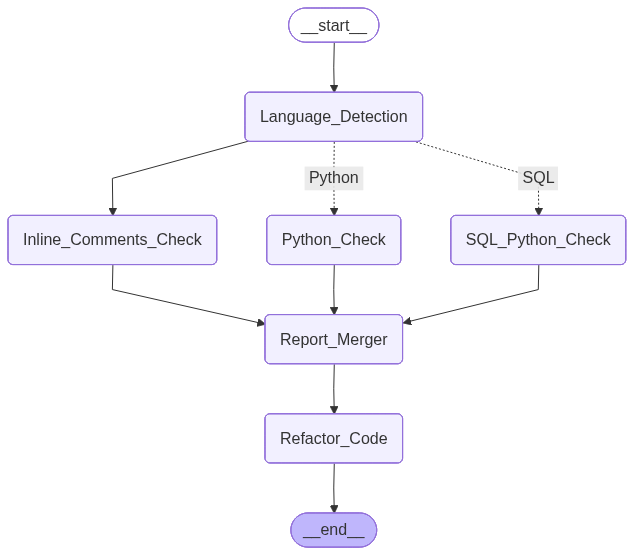

In [10]:
# Code Style and Consistency Agent is defined via LangGraph workflow
from IPython.display import Image, display
graph = create_code_quality_graph()
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
def load_code_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return f.read()

In [12]:
# Constants

# File Level Review Lists
codeStyle_file_level_review_list = []
dry_file_level_review_list = []
security_file_level_review_list = []
    
# Line Level Review Lists
codeStyle_line_level_review_list = []
dry_line_level_review_list = []
security_line_level_review_list = []

# folder_path = 'Test_Repository'

# Creating Report 

In [13]:
def create_repo_level_df():
    
    # Code Style and Consistency
    codeStyle_file_level_issue_summary_list = []
    codeStyle_file_level_refactor_summary_list = []
    codeStyle_violations = 0
    codeStyle_score = 0
    codeStyle_score_avg = 0
    for single_dict in codeStyle_file_level_review_list:
        codeStyle_file_level_issue_summary_list.append(single_dict["issue_summary"])
        codeStyle_file_level_refactor_summary_list.append(single_dict["refactor_summary"])
        codeStyle_violations += single_dict["violations"]
        codeStyle_score += single_dict["score"]

    if codeStyle_file_level_review_list:
        codeStyle_score_avg = codeStyle_score / len(codeStyle_file_level_review_list)
    else:
        codeStyle_score_avg = 0

    codeStyle_repo_level_issue_summary = generate_overall_issue_summary("Code Style and Consistency", codeStyle_file_level_issue_summary_list)
    codeStyle_repo_level_refactor_summary = generate_overall_refactor_summary("Code Style and Consistency", codeStyle_file_level_refactor_summary_list)
    
    # DRY and Modularity
    dry_file_level_issue_summary_list = []
    dry_file_level_refactor_summary_list = []
    dry_violations = 0
    dry_score = 0
    dry_score_avg = 0
    for single_dict in dry_file_level_review_list:
        dry_file_level_issue_summary_list.append(single_dict["issue_summary"])
        dry_file_level_refactor_summary_list.append(single_dict["refactor_summary"])
        dry_violations += single_dict["violations"]
        dry_score += single_dict["score"]

    if dry_file_level_review_list:
        dry_score_avg = dry_score / len(dry_file_level_review_list)
    else:
        dry_score_avg = 0

    dry_repo_level_issue_summary = generate_overall_issue_summary("DRY and Modularity", dry_file_level_issue_summary_list)
    dry_repo_level_refactor_summary = generate_overall_refactor_summary("DRY and Modularity", dry_file_level_refactor_summary_list)
    
    
    # Security Compliances
    security_file_level_issue_summary_list = []
    security_file_level_refactor_summary_list = []
    security_violations = 0
    security_score = 0
    security_score_avg = 0
    for single_dict in security_file_level_review_list:
        security_file_level_issue_summary_list.append(single_dict["issue_summary"])
        security_file_level_refactor_summary_list.append(single_dict["refactor_summary"])
        security_violations += single_dict["violations"]
        security_score += single_dict["score"]

    if security_file_level_review_list:
        security_score_avg = security_score / len(security_file_level_review_list)
    else:
        security_score_avg = 0

    security_repo_level_issue_summary = generate_overall_issue_summary("Security Compliances", security_file_level_issue_summary_list)
    security_repo_level_refactor_summary = generate_overall_refactor_summary("Security Compliances", security_file_level_refactor_summary_list)
    
    # Overall Results
    overall_violations = codeStyle_violations + dry_violations + security_violations
    overall_score_avg = (security_score_avg + dry_score_avg + codeStyle_score_avg) / 3
    overall_repo_level_issue_summary = generate_overall_repo_issue_summary(codeStyle_repo_level_issue_summary, dry_repo_level_issue_summary, security_repo_level_issue_summary)
    overall_repo_level_refactor_summary = generate_overall_repo_refactor_summary(codeStyle_repo_level_refactor_summary, dry_repo_level_refactor_summary, security_repo_level_refactor_summary)
    
    # Create Repo Level DataFrame
    repo_level_data = [
        {"Review Category": "Code Style and Consistency", "Vulnerabilities Flagged": codeStyle_violations, "AI Review Score": codeStyle_score_avg, "AI Reviewer Comments": codeStyle_repo_level_issue_summary, "AI Suggested Fixes": codeStyle_repo_level_refactor_summary},
        {"Review Category": "DRY and Modularity", "Vulnerabilities Flagged": dry_violations, "AI Review Score": dry_score_avg, "AI Reviewer Comments": dry_repo_level_issue_summary, "AI Suggested Fixes": dry_repo_level_refactor_summary},
        {"Review Category": "Security Compliences", "Vulnerabilities Flagged": security_violations, "AI Review Score": security_score_avg, "AI Reviewer Comments": security_repo_level_issue_summary, "AI Suggested Fixes": security_repo_level_refactor_summary},
        {"Review Category": "Overall", "Vulnerabilities Flagged": overall_violations, "AI Review Score": overall_score_avg, "AI Reviewer Comments": overall_repo_level_issue_summary, "AI Suggested Fixes": overall_repo_level_refactor_summary}
    ]

    final_repo_review_df = pd.DataFrame(repo_level_data)
    return final_repo_review_df    
    

In [14]:
def create_file_level_df():
    
    codeStyle_file_level_df = pd.DataFrame(codeStyle_file_level_review_list)
    dry_file_level_df = pd.DataFrame(dry_file_level_review_list)
    security_file_level_df = pd.DataFrame(security_file_level_review_list)

    # Merge the Dataframes
    file_level_merged = pd.concat([codeStyle_file_level_df, dry_file_level_df, security_file_level_df], ignore_index=True)
    return file_level_merged

In [15]:
def create_line_level_df():
    codeStyle_line_level_df = pd.DataFrame(codeStyle_line_level_review_list)
    dry_line_level_df = pd.DataFrame(dry_line_level_review_list)
    security_line_level_df = pd.DataFrame(security_line_level_review_list)

    # Changing Column Names
    codeStyle_line_level_df = codeStyle_line_level_df.rename(columns={
        'refactored_python_script': 'refactored_script',
        'original_python_script': 'original_code_script'
    })
    
    dry_line_level_df = dry_line_level_df.rename(columns={
        'original_sql_script': 'original_code_script'
    })

    # Merge the Dataframes
    line_level_merged = pd.concat([codeStyle_line_level_df, dry_line_level_df, security_line_level_df], ignore_index=True)
    return line_level_merged

# UI

In [16]:
UPLOAD_DIR = "uploaded_folder_gradio"
os.makedirs(UPLOAD_DIR, exist_ok=True)

def clear_uploaded_files():
    """Clears the contents of the UPLOAD_DIR."""
    try:
        if os.path.exists(UPLOAD_DIR):
            for filename in os.listdir(UPLOAD_DIR):
                file_path = os.path.join(UPLOAD_DIR, filename)
                if os.path.isfile(file_path):
                    os.remove(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
    except Exception as e:
        print(f"Error clearing files: {e}")
        raise gr.Error(f"Error clearing files: {e}")
        
def create_repo_summary_table():
    df = create_repo_level_df()
    # df = pd.read_excel('code_review_report_test.xlsx', sheet_name='Repository Review')
    return df if not df.empty else pd.DataFrame([{"No data": "Repository summary is empty"}])


def process_uploaded_files(files):
    if not files:
        yield 0, "Please upload files first.", gr.update(visible=False), gr.update(visible=False), None
        return

    total_files = len(files)
    processed = 0
    
    # Calculate total steps: 3 agents per file
    total_steps = total_files * 3 
    current_step = 0

    yield 0, f"Processing {total_files} files...", gr.update(visible=False), gr.update(visible=False), None

    # Save uploaded files
    for temp_file in files:
        original_filename = os.path.basename(temp_file.name)
        if hasattr(temp_file, 'orig_name') and temp_file.orig_name:
            original_filename = temp_file.orig_name

        file_path = os.path.join(UPLOAD_DIR, original_filename)
        shutil.copy(temp_file.name, file_path)

    # Process each file
    for filename in os.listdir(UPLOAD_DIR):
        file_path = os.path.join(UPLOAD_DIR, filename)

        if not os.path.isfile(file_path) or not (file_path.endswith(".py") or file_path.endswith(".sql")):
            continue

        # File processing step
        # current_step += 1
        progress = int((current_step / total_steps) * 100)
        yield progress, f"🔍 Processing file: {filename}", gr.update(visible=False), gr.update(visible=False), None

        try:
            # Code Style Agent
            yield progress, f"🧹 Running Code Style & Consistency Agent for file {filename}", gr.update(visible=False), gr.update(visible=False), None
            graph = create_code_quality_graph()
            codeStyle_response = graph.invoke({"filename": file_path})["evaluationReport"]
            print("###code style response###", codeStyle_response)
            
            # Update progress 
            current_step += 1
            progress = int((current_step / total_steps) * 100)
            yield progress, f"✅ Code Style Agent completed for {filename}.", gr.update(visible=False), gr.update(visible=False), None
            
            # DRY Agent
            yield progress, f"🔁 Running DRY & Modularity Agent for file {filename}", gr.update(visible=False), gr.update(visible=False), None
            
            dry_response = run_dry_modularity_compliance_agent(file_path)
            print("##dry response##", dry_response)
            
            # Update progress 
            current_step += 1
            progress = int((current_step / total_steps) * 100)
            yield progress, f"✅ DRY & Modularity Agent completed for {filename}.", gr.update(visible=False), gr.update(visible=False), None

            # Security Agent
            yield progress, f"🔐 Running Security Compliance Agent for file {filename}", gr.update(visible=False), gr.update(visible=False), None
            security_response = run_security_compliance_agent(file_path)
            print("##security response##", security_response)
            
            # Update progress 
            current_step += 1
            progress = int((current_step / total_steps) * 100)
            yield progress, f"✅ Security Compliance Agent completed for {filename}.", gr.update(visible=False), gr.update(visible=False), None

            # File level data
            codeStyle_file_level_review_list.append({
                "filename": filename,
                "category": "Code Style & Consistency",
                "score": codeStyle_response["evaluation_score"],
                "issue_summary": codeStyle_response["evaluation_issue_summary"],
                "refactor_summary": codeStyle_response["evaluation_refactor_summary"],
                "violations": codeStyle_response["violations_count"]
            })

            dry_file_level_review_list.append({
                "filename": filename,
                "category": "DRY & Modularity",
                "score": dry_response["evaluation_score"],
                "issue_summary": dry_response["evaluation_issue_summary"],
                "refactor_summary": dry_response["evaluation_refactor_summary"],
                "violations": len(dry_response["evaluation_details"])
            })

            security_file_level_review_list.append({
                "filename": filename,
                "category": "Security Compliance",
                "score": security_response["evaluation_score"],
                "issue_summary": security_response["evaluation_issue_summary"],
                "refactor_summary": security_response["evaluation_refactor_summary"],
                "violations": len(security_response["evaluation_details"])
            })

            # Line Level Reviews
            x = codeStyle_response["evaluation_details"]
            y = dry_response["evaluation_details"]
            z = security_response["evaluation_details"]

            for i in x:
                i["filename"] = filename
                i["category"] = "Code Style & Consistency"
                codeStyle_line_level_review_list.append(i)

            for i in y:
                i["filename"] = filename
                i["category"] = "DRY and Modularity"
                dry_line_level_review_list.append(i)

            for i in z:
                i["filename"] = filename
                i["category"] = "Security Compliance"
                security_line_level_review_list.append(i)

        except Exception as agent_err:
            # Still increment step counter even on error to maintain progress accuracy
            current_step += 3  # Skip the remaining 3 steps for this file
            progress = int((current_step / total_steps) * 100)
            yield progress, f"❌ Error processing {filename}: {agent_err}", gr.update(visible=False), gr.update(visible=False), None

        processed += 1
        yield progress, f"🏁 Finished Reviewing {filename} ({processed}/{total_files})", gr.update(visible=False), gr.update(visible=False), None

    clear_uploaded_files()
    repo_df = create_repo_summary_table()
    yield 100, "✅ All files processed. See summary below.", gr.update(visible=True), gr.update(value=repo_df, visible=True), None
    # yield 100, "✅ All files processed. You can now generate the report.", gr.update(visible=True), None


def generate_excel_report():
    """
    Generates the multi-sheet Excel report and returns its path for download.
    Enhanced with step-by-step progress tracking.
    """
    total_steps = 3  # Create repo df, file df, line df, write Excel
    current_step = 0
    
    # Step 1: Create repository level dataframe
    # current_step += 1
    progress = int((current_step / total_steps) * 100)
    yield progress, "📊 Creating repository level analysis...", None
    
    try:
        # Step 1: Create repository level dataframe
        yield progress, "📊 Creating repository level analysis...", None
        final_repo_review_df = create_repo_level_df()
        
        # Update progress AFTER repo analysis is complete
        current_step += 1
        progress = int((current_step / total_steps) * 100)
        yield progress, "✅ Repository level analysis completed.", None
        
        # Step 2: Create file level dataframe  
        yield progress, "📁 Creating file level analysis...", None
        file_level_merged_df = create_file_level_df()
        
        # Update progress AFTER file analysis is complete
        current_step += 1
        progress = int((current_step / total_steps) * 100)
        yield progress, "✅ File level analysis completed.", None
        
        # Step 3: Create line level dataframe
        yield progress, "📝 Creating line level analysis...", None
        line_level_merged_df = create_line_level_df()
        
        # Update progress AFTER line analysis is complete
        current_step += 1
        progress = int((current_step / total_steps) * 100)
        yield progress, "✅ Line level analysis completed.", None
        
        # Step 4: Generate Excel file
        yield progress, "💾 Generating Excel file...", None
        
        output_dir = "ai_code_review_reports"
        os.makedirs(output_dir, exist_ok=True)
        
        filename = f"code_review_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx"
        output_file = os.path.join(output_dir, filename)

        with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
            final_repo_review_df.to_excel(writer, sheet_name='Repository Review', index=False)
            file_level_merged_df.to_excel(writer, sheet_name='Files Review', index=False)
            line_level_merged_df.to_excel(writer, sheet_name='Line Level Review', index=False)

        # Update progress AFTER Excel file is generated
        current_step += 1
        progress = int((current_step / total_steps) * 100)
        status_message = f"✅ Excel report generated successfully! Click below to download."
        yield 100, status_message, gr.update(value=output_file, visible=True)

    except Exception as e:
        error_message = f"❌ Error generating Excel: {e}"
        print(error_message)
        raise gr.Error(error_message)

In [17]:
# --- Gradio UI ---
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🧠 AI Code Review Report Generator")
    gr.Markdown("Upload `.py` or `.sql` files. Run code quality agents, then export the report.")

    with gr.Row():
        with gr.Column(scale=1):
            upload_button = gr.File(label="Upload Code Files", file_count="multiple", file_types=['.py', '.sql'])
        with gr.Column(scale=2):
            progress_bar = gr.Slider(minimum=0, maximum=100, value=0, interactive=False, label="Progress")
            status_text = gr.Text(label="Status Message", value="Ready to upload files...")

    # Full-width repo summary table
    repo_summary_table = gr.Dataframe(
        label="📘 Repository Summary",
        visible=False,
        interactive=False,
        wrap=True
    )

    export_button = gr.Button("Generate Detailed Review", variant="primary", visible=False)
    download_link = gr.File(label="Download Report", visible=False)

    upload_button.upload(
        fn=process_uploaded_files,
        inputs=upload_button,
        outputs=[progress_bar, status_text, export_button, repo_summary_table, download_link]
    )

    export_button.click(
        fn=generate_excel_report,
        inputs=None,
        outputs=[progress_bar, status_text, download_link]
    )

if __name__ == "__main__":
    demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://afe9e7abbb1c92d1c6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
